In [4]:
import os
import math
import time
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, Module
from torch.optim.lr_scheduler import ExponentialLR
from torchmetrics import AUROC, Accuracy, MeanSquaredError
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

from torch_frame import stype
from torch_frame.data import Dataset, DataLoader
from torch_frame.datasets import (
    ForestCoverType, KDDCensusIncome, DataFrameBenchmark,
    AdultCensusIncome, BankMarketing, Dota2
)
from torch_frame.gbdt import CatBoost, LightGBM, XGBoost
from torch_frame.nn import (
    EmbeddingEncoder, FTTransformer, LinearBucketEncoder,
    LinearEncoder, LinearPeriodicEncoder, ResNet, TabNet, TabTransformer
)
from torch_frame.nn.models import (
    MLP, ExcelFormer, Trompt
)
from torch_frame.typing import TaskType



# Use GPU for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ML

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
import catboost as cb
import optuna
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [6]:
df = pd.read_csv("Breast_Cancer.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Status'] = le.fit_transform(df['Status'])
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,0
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,0
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,0
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,0
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,0


In [9]:
# Heart Disease를 종속 변수(y)로 설정
y_col = "Status"
y = df[y_col]

X = df.drop(columns=[y_col])

# 연속형 변수 (float, int)와 범주형 변수 분리
continuous_vars = X.select_dtypes(include=["int64"]).columns
categorical_vars = X.select_dtypes(include=["object"]).columns
continuous_vars = [col for col in continuous_vars if col not in categorical_vars]

In [10]:
df_encoded = pd.get_dummies(df, columns=categorical_vars)
df_encoded.head()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months,Status,Race_Black,Race_Other,Race_White,Marital Status_Divorced,...,Grade_ anaplastic; Grade IV,Grade_1,Grade_2,Grade_3,A Stage_Distant,A Stage_Regional,Estrogen Status_Negative,Estrogen Status_Positive,Progesterone Status_Negative,Progesterone Status_Positive
0,68,4,24,1,60,0,False,False,True,False,...,False,False,False,True,False,True,False,True,False,True
1,50,35,14,5,62,0,False,False,True,False,...,False,False,True,False,False,True,False,True,False,True
2,58,63,14,7,75,0,False,False,True,True,...,False,False,True,False,False,True,False,True,False,True
3,58,18,2,1,84,0,False,False,True,False,...,False,False,False,True,False,True,False,True,False,True
4,47,41,3,1,50,0,False,False,True,False,...,False,False,False,True,False,True,False,True,False,True


In [11]:
y = df_encoded[y_col]
X = df_encoded.drop(columns=[y_col])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y)

## Model

### Logistic Regression

In [13]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
log_acc = accuracy_score(y_test, y_pred_log)
print(f'Logistic Regression Accuracy: {log_acc:.4f}')

Logistic Regression Accuracy: 0.8932


c:\Users\cleo7\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Random Forest

In [14]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_acc:.4f}')

Random Forest Accuracy: 0.8919


### Decision Tree

In [15]:
dt_params = {'max_depth': [3, 5, 10, 15, None]}
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy')
dt_grid.fit(X_train, y_train)
dt_best = dt_grid.best_estimator_

y_pred_dt = dt_best.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt)

print("🔹 Decision Tree Results:")
print("Best Parameters:", dt_grid.best_params_)
print("Accuracy:", acc_dt)
print(classification_report(y_test, y_pred_dt))

🔹 Decision Tree Results:
Best Parameters: {'max_depth': 5}
Accuracy: 0.8881987577639752
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       682
           1       0.73      0.42      0.54       123

    accuracy                           0.89       805
   macro avg       0.82      0.70      0.74       805
weighted avg       0.88      0.89      0.88       805



### XGBoost

In [16]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print("🔹 XGBoost Classifier Results:")
print("Accuracy:", acc_xgb)
print(classification_report(y_test, y_pred_xgb))

🔹 XGBoost Classifier Results:
Accuracy: 0.8956521739130435
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       682
           1       0.76      0.46      0.58       123

    accuracy                           0.90       805
   macro avg       0.83      0.72      0.76       805
weighted avg       0.89      0.90      0.88       805



c:\Users\cleo7\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:56:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


### LightGBM

In [17]:
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', num_leaves=31, learning_rate=0.05, 
                                 n_estimators=200, force_col_wise=True, random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

acc_lgb = accuracy_score(y_test, y_pred_lgb)

print("🔹 LightGBM Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 493, number of negative: 2726
[LightGBM] [Info] Total Bins 375
[LightGBM] [Info] Number of data points in the train set: 3219, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.153153 -> initscore=-1.710081
[LightGBM] [Info] Start training from score -1.710081
🔹 LightGBM Model Performance 🔹
Accuracy: 0.8956521739130435
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       682
           1       0.74      0.49      0.59       123

    accuracy                           0.90       805
   macro avg       0.83      0.73      0.76       805
weighted avg       0.89      0.90      0.89       805



### CatBoost

In [18]:
cat_model = cb.CatBoostClassifier(iterations=200, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)

print("🔹 CatBoost Model Performance 🔹")
print("Accuracy:", accuracy_score(y_test, y_pred_cat))
print(classification_report(y_test, y_pred_cat))

🔹 CatBoost Model Performance 🔹
Accuracy: 0.8968944099378882
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       682
           1       0.77      0.46      0.58       123

    accuracy                           0.90       805
   macro avg       0.84      0.72      0.76       805
weighted avg       0.89      0.90      0.89       805



# DL

In [19]:
df = pd.read_csv("Breast_Cancer.csv")

In [20]:
# 분류 task
is_classification = True

In [21]:
from torch_frame import numerical, categorical, text_embedded, embedding

## 칼럼 별 Dtype 지정 
col_to_stype={"Age" : numerical,
              "Race" : categorical,
              "Marital Status" : categorical,
              "T Stage " : categorical,
              "N Stage" : categorical,
              "6th Stage" : categorical,
              "differentiate" : categorical,
              "Grade" : categorical,
              "A Stage" : categorical,
              "Tumor Size" : numerical,
              "Estrogen Status" : categorical,
              "Progesterone Status" : categorical,
              "Regional Node Examined" : numerical,
              "Reginol Node Positive" : numerical,
              "Survival Months" : numerical,
              "Status" : categorical}

dataset = Dataset(df=df, 
                  col_to_stype=col_to_stype, 
                  target_col='Status')

dataset.materialize()

## split
train_dataset, val_dataset, test_dataset = dataset[:0.6], dataset[0.6:0.7], dataset[0.7:]

### ResNet

In [22]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [23]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'resnet',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [24]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [25]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [26]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [27]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 10/10 [00:00<00:00, 22.52it/s]


Train Loss: 0.4660, Train Acc: 0.8517, Val Acc: 0.8387, Test Acc: 0.8616


Epoch: 2: 100%|██████████| 10/10 [00:00<00:00, 18.71it/s]


Train Loss: 0.3834, Train Acc: 0.8546, Val Acc: 0.8462, Test Acc: 0.8592


Epoch: 3: 100%|██████████| 10/10 [00:00<00:00, 19.37it/s]


Train Loss: 0.3789, Train Acc: 0.8550, Val Acc: 0.8511, Test Acc: 0.8575


Epoch: 4: 100%|██████████| 10/10 [00:00<00:00, 23.56it/s]


Train Loss: 0.3744, Train Acc: 0.8579, Val Acc: 0.8486, Test Acc: 0.8558


Epoch: 5: 100%|██████████| 10/10 [00:00<00:00, 22.98it/s]


Train Loss: 0.3730, Train Acc: 0.8600, Val Acc: 0.8462, Test Acc: 0.8558


Epoch: 6: 100%|██████████| 10/10 [00:00<00:00, 24.33it/s]


Train Loss: 0.3661, Train Acc: 0.8625, Val Acc: 0.8437, Test Acc: 0.8592


Epoch: 7: 100%|██████████| 10/10 [00:00<00:00, 23.64it/s]


Train Loss: 0.3645, Train Acc: 0.8625, Val Acc: 0.8511, Test Acc: 0.8616


Epoch: 8: 100%|██████████| 10/10 [00:00<00:00, 23.33it/s]


Train Loss: 0.3653, Train Acc: 0.8654, Val Acc: 0.8536, Test Acc: 0.8567


Epoch: 9: 100%|██████████| 10/10 [00:00<00:00, 21.71it/s]


Train Loss: 0.3513, Train Acc: 0.8612, Val Acc: 0.8486, Test Acc: 0.8666


Epoch: 10: 100%|██████████| 10/10 [00:00<00:00, 21.80it/s]


Train Loss: 0.3521, Train Acc: 0.8712, Val Acc: 0.8586, Test Acc: 0.8600


Epoch: 11: 100%|██████████| 10/10 [00:00<00:00, 20.37it/s]


Train Loss: 0.3412, Train Acc: 0.8778, Val Acc: 0.8635, Test Acc: 0.8699


Epoch: 12: 100%|██████████| 10/10 [00:00<00:00, 26.02it/s]


Train Loss: 0.3304, Train Acc: 0.8832, Val Acc: 0.8784, Test Acc: 0.8749


Epoch: 13: 100%|██████████| 10/10 [00:00<00:00, 23.28it/s]


Train Loss: 0.3159, Train Acc: 0.8857, Val Acc: 0.8784, Test Acc: 0.8815


Epoch: 14: 100%|██████████| 10/10 [00:00<00:00, 21.85it/s]


Train Loss: 0.2997, Train Acc: 0.8927, Val Acc: 0.8933, Test Acc: 0.8898


Epoch: 15: 100%|██████████| 10/10 [00:00<00:00, 21.44it/s]


Train Loss: 0.2950, Train Acc: 0.8952, Val Acc: 0.8958, Test Acc: 0.8940
Best Val Acc: 0.8958, Best Test Acc: 0.8940


In [28]:
resnet_score = best_test_metric
resnet_score

0.8939519469759735

### FT-T

In [29]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='adult')
parser.add_argument('--numerical_encoder_type', type=str, default='linear',
                    choices=['linear', 'linearbucket', 'linearperiodic'])
parser.add_argument('--model_type', type=str, default='fttransformer',
                    choices=['fttransformer', 'resnet'])
parser.add_argument('--channels', type=int, default=256)
parser.add_argument('--num_layers', type=int, default=4)
parser.add_argument('--batch_size', type=int, default=512)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=100)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

_StoreTrueAction(option_strings=['--compile'], dest='compile', nargs=0, const=True, default=False, type=None, choices=None, required=False, help=None, metavar=None)

In [30]:
# Jupyter에서 실행될 때는 sys.argv를 조정
args = parser.parse_args([
    #'--dataset', 'adult',
    '--numerical_encoder_type', 'linear',
    '--model_type', 'fttransformer',       # fttransformer : FT-T / resnet : ResNet
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [31]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

if args.numerical_encoder_type == 'linear':
    numerical_encoder = LinearEncoder()
elif args.numerical_encoder_type == 'linearbucket':
    numerical_encoder = LinearBucketEncoder()
elif args.numerical_encoder_type == 'linearperiodic':
    numerical_encoder = LinearPeriodicEncoder()
else:
    raise ValueError(
        f'Unsupported encoder type: {args.numerical_encoder_type}')

stype_encoder_dict = {
    stype.categorical: EmbeddingEncoder(),
    stype.numerical: numerical_encoder,
}

if is_classification:
    #output_channels = dataset.num_classes    ->   contains StatType.COUNT을 포함하지 않아서 오류(?)
    output_channels = 2 # 그냥 수동으로 설정.,,,,   => 분류 칼럼 unique 개수로 설정 
else:
    output_channels = 1

In [32]:
if args.model_type == 'fttransformer':
    model = FTTransformer(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,    # TensorFrame이 col_stats를 안받아서 transor frame으로 바꾸기 전으로 받아와야 함 
        col_names_dict=train_tensor_frame.col_names_dict,
        stype_encoder_dict=stype_encoder_dict,
    ).to(device)

elif args.model_type == 'resnet':
    model = ResNet(
        channels=args.channels,
        out_channels=output_channels,
        num_layers=args.num_layers,
        col_stats=dataset.col_stats,
        col_names_dict=train_tensor_frame.col_names_dict,
    ).to(device)
else:
    raise ValueError(f'Unsupported model type: {args.model_type}')

model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

In [33]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            loss = F.cross_entropy(pred, tf.y.long())
        else:
            loss = F.mse_loss(pred.view(-1), tf.y.view(-1))
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse


In [34]:
# 훈련 및 테스트

if is_classification:
    metric = 'Acc'
    best_val_metric = 0
    best_test_metric = 0
else:
    metric = 'RMSE'
    best_val_metric = float('inf')
    best_test_metric = float('inf')

for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if is_classification and val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric
    elif not is_classification and val_metric < best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')


Epoch: 1: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Train Loss: 0.5159, Train Acc: 0.8447, Val Acc: 0.8387, Test Acc: 0.8542


Epoch: 2: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


Train Loss: 0.4311, Train Acc: 0.8447, Val Acc: 0.8387, Test Acc: 0.8542


Epoch: 3: 100%|██████████| 10/10 [00:03<00:00,  2.50it/s]


Train Loss: 0.4007, Train Acc: 0.8505, Val Acc: 0.8387, Test Acc: 0.8567


Epoch: 4: 100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


Train Loss: 0.3903, Train Acc: 0.8554, Val Acc: 0.8387, Test Acc: 0.8625


Epoch: 5: 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]


Train Loss: 0.3763, Train Acc: 0.8471, Val Acc: 0.8486, Test Acc: 0.8476


Epoch: 6: 100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


Train Loss: 0.3772, Train Acc: 0.8563, Val Acc: 0.8437, Test Acc: 0.8517


Epoch: 7: 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


Train Loss: 0.3788, Train Acc: 0.8517, Val Acc: 0.8462, Test Acc: 0.8459


Epoch: 8: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Train Loss: 0.3791, Train Acc: 0.8558, Val Acc: 0.8412, Test Acc: 0.8567


Epoch: 9: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Train Loss: 0.3758, Train Acc: 0.8583, Val Acc: 0.8437, Test Acc: 0.8600


Epoch: 10: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Train Loss: 0.3762, Train Acc: 0.8558, Val Acc: 0.8437, Test Acc: 0.8583


Epoch: 11: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


Train Loss: 0.3746, Train Acc: 0.8579, Val Acc: 0.8437, Test Acc: 0.8592


Epoch: 12: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


Train Loss: 0.3734, Train Acc: 0.8567, Val Acc: 0.8437, Test Acc: 0.8592


Epoch: 13: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


Train Loss: 0.3718, Train Acc: 0.8592, Val Acc: 0.8412, Test Acc: 0.8592


Epoch: 14: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Train Loss: 0.3708, Train Acc: 0.8587, Val Acc: 0.8412, Test Acc: 0.8600


Epoch: 15: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


Train Loss: 0.3668, Train Acc: 0.8616, Val Acc: 0.8437, Test Acc: 0.8600
Best Val Acc: 0.8486, Best Test Acc: 0.8476


In [35]:
ftt_score = best_test_metric
ftt_score

0.8475559237779619

### TabNet

In [36]:
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default="ForestCoverType",
                    choices=["ForestCoverType", "KDDCensusIncome"])
parser.add_argument('--channels', type=int, default=128)
parser.add_argument('--gamma', type=int, default=1.2)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--batch_size', type=int, default=4096)
parser.add_argument('--lr', type=float, default=0.005)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')


args = parser.parse_args([
    "--channels", "256",
    "--num_layers", "4",
    "--batch_size", "256",
    "--lr", "0.0001",
    "--epochs", "15"
])

torch.manual_seed(args.seed)

In [37]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [38]:
# Set up model and optimizer
model = TabNet(
    out_channels = 2,
    num_layers=args.num_layers,
    split_attn_channels=args.channels,
    split_feat_channels=args.channels,
    gamma=args.gamma,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [39]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model(tf)
        loss = F.cross_entropy(pred, tf.y.long())
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        pred_class = pred.argmax(dim=-1)
        accum += float((tf.y == pred_class).sum())
        total_count += len(tf.y)

    return accum / total_count

In [40]:
best_val_acc = 0
best_test_acc = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    val_acc = test(val_loader)
    test_acc = test(test_loader)
    if best_val_acc < val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
    lr_scheduler.step()

print(f'Best Val Acc: {best_val_acc:.4f}, Best Test Acc: {best_test_acc:.4f}')

Epoch: 1: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s]


Train Loss: 0.7130, Train Acc: 0.1553, Val Acc: 0.1613, Test Acc: 0.1458


Epoch: 2: 100%|██████████| 10/10 [00:01<00:00,  7.90it/s]


Train Loss: 0.6889, Train Acc: 0.1727, Val Acc: 0.1712, Test Acc: 0.1582


Epoch: 3: 100%|██████████| 10/10 [00:01<00:00,  7.96it/s]


Train Loss: 0.6513, Train Acc: 0.3368, Val Acc: 0.3548, Test Acc: 0.3157


Epoch: 4: 100%|██████████| 10/10 [00:01<00:00,  8.09it/s]


Train Loss: 0.6104, Train Acc: 0.5638, Val Acc: 0.5906, Test Acc: 0.5427


Epoch: 5: 100%|██████████| 10/10 [00:01<00:00,  8.74it/s]


Train Loss: 0.5690, Train Acc: 0.7121, Val Acc: 0.7047, Test Acc: 0.6802


Epoch: 6: 100%|██████████| 10/10 [00:01<00:00,  7.85it/s]


Train Loss: 0.5230, Train Acc: 0.7875, Val Acc: 0.7891, Test Acc: 0.7655


Epoch: 7: 100%|██████████| 10/10 [00:01<00:00,  7.99it/s]


Train Loss: 0.4796, Train Acc: 0.8277, Val Acc: 0.8313, Test Acc: 0.8161


Epoch: 8: 100%|██████████| 10/10 [00:01<00:00,  8.33it/s]


Train Loss: 0.4368, Train Acc: 0.8583, Val Acc: 0.8511, Test Acc: 0.8459


Epoch: 9: 100%|██████████| 10/10 [00:01<00:00,  8.44it/s]


Train Loss: 0.3941, Train Acc: 0.8691, Val Acc: 0.8486, Test Acc: 0.8691


Epoch: 10: 100%|██████████| 10/10 [00:01<00:00,  8.25it/s]


Train Loss: 0.3594, Train Acc: 0.8782, Val Acc: 0.8660, Test Acc: 0.8766


Epoch: 11: 100%|██████████| 10/10 [00:01<00:00,  8.13it/s]


Train Loss: 0.3350, Train Acc: 0.8890, Val Acc: 0.8710, Test Acc: 0.8790


Epoch: 12: 100%|██████████| 10/10 [00:01<00:00,  8.15it/s]


Train Loss: 0.3126, Train Acc: 0.8944, Val Acc: 0.8710, Test Acc: 0.8848


Epoch: 13: 100%|██████████| 10/10 [00:01<00:00,  8.50it/s]


Train Loss: 0.2997, Train Acc: 0.8977, Val Acc: 0.8685, Test Acc: 0.8898


Epoch: 14: 100%|██████████| 10/10 [00:01<00:00,  8.12it/s]


Train Loss: 0.2820, Train Acc: 0.9031, Val Acc: 0.8734, Test Acc: 0.8898


Epoch: 15: 100%|██████████| 10/10 [00:01<00:00,  8.61it/s]


Train Loss: 0.2775, Train Acc: 0.9068, Val Acc: 0.8710, Test Acc: 0.8940
Best Val Acc: 0.8734, Best Test Acc: 0.8898


In [41]:
tabnet_score = best_test_acc
tabnet_score

0.8898094449047225

### Tab_Transformer

In [42]:
# Jupyter에서 실행될 때는 sys.argv를 조정
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='dota2',
                    choices=["adult", "dota2", "bank-marketing"])
parser.add_argument('--channels', type=int, default=32)
parser.add_argument('--num_heads', type=int, default=8)
parser.add_argument('--num_layers', type=int, default=6)
parser.add_argument('--encoder_pad_size', type=int, default=2)
parser.add_argument('--attention_dropout', type=float, default=0.3)
parser.add_argument('--ffn_dropout', type=float, default=0.3)
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.0001)
parser.add_argument('--epochs', type=int, default=50)
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--compile', action='store_true')

args = parser.parse_args([
    '--channels', '256',
    '--num_layers', '4',
    '--batch_size', '256',  # 데이터를 256개씩 한번에 
    '--lr', '0.0001',
    '--epochs', '15',
    '--seed', '0'
])

In [43]:
# Set up data loaders
train_tensor_frame = train_dataset.tensor_frame
val_tensor_frame = val_dataset.tensor_frame
test_tensor_frame = test_dataset.tensor_frame
train_loader = DataLoader(train_tensor_frame, batch_size=args.batch_size,
                          shuffle=True)
val_loader = DataLoader(val_tensor_frame, batch_size=args.batch_size)
test_loader = DataLoader(test_tensor_frame, batch_size=args.batch_size)

In [44]:
# Set up model and optimizer
model = TabTransformer(
    channels=args.channels,
    out_channels= 2,        # stype 문제로 수동으로 설정 
    num_layers=args.num_layers,
    num_heads=args.num_heads,
    encoder_pad_size=args.encoder_pad_size,
    attn_dropout=args.attention_dropout,
    ffn_dropout=args.ffn_dropout,
    col_stats=dataset.col_stats,
    col_names_dict=train_tensor_frame.col_names_dict,
).to(device)
model = torch.compile(model, dynamic=True) if args.compile else model
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
lr_scheduler = ExponentialLR(optimizer, gamma=0.95)

In [45]:
def train(epoch: int) -> float:
    model.train()
    loss_accum = total_count = 0

    for tf in tqdm(train_loader, desc=f'Epoch: {epoch}'):
        tf = tf.to(device)
        pred = model.forward(tf)
        loss = F.cross_entropy(pred, tf.y.long())   # expected scalar type Long but found Float 때문에 tf.y => tf.y.long()
        optimizer.zero_grad()
        loss.backward()
        loss_accum += float(loss) * len(tf.y)
        total_count += len(tf.y)
        optimizer.step()
    return loss_accum / total_count


@torch.no_grad()
def test(loader: DataLoader) -> float:
    model.eval()
    accum = total_count = 0

    for tf in loader:
        tf = tf.to(device)
        pred = model(tf)
        if is_classification:
            pred_class = pred.argmax(dim=-1)
            accum += float((tf.y == pred_class).sum())
        else:
            accum += float(
                F.mse_loss(pred.view(-1), tf.y.view(-1), reduction='sum'))
        total_count += len(tf.y)

    if is_classification:
        accuracy = accum / total_count
        return accuracy
    else:
        rmse = (accum / total_count)**0.5
        return rmse

In [46]:
metric = 'ACC'
best_val_metric = 0
best_test_metric = 0
for epoch in range(1, args.epochs + 1):
    train_loss = train(epoch)
    train_metric = test(train_loader)
    val_metric = test(val_loader)
    test_metric = test(test_loader)

    if val_metric > best_val_metric:
        best_val_metric = val_metric
        best_test_metric = test_metric

    print(f'Train Loss: {train_loss:.4f}, Train {metric}: {train_metric:.4f}, '
          f'Val {metric}: {val_metric:.4f}, Test {metric}: {test_metric:.4f}')
    lr_scheduler.step()

print(f'Best Val {metric}: {best_val_metric:.4f}, '
      f'Best Test {metric}: {best_test_metric:.4f}')

Epoch: 1: 100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


Train Loss: 1.3469, Train ACC: 0.6669, Val ACC: 0.6774, Test ACC: 0.6330


Epoch: 2: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Train Loss: 1.2006, Train ACC: 0.7680, Val ACC: 0.7742, Test ACC: 0.7498


Epoch: 3: 100%|██████████| 10/10 [00:11<00:00,  1.20s/it]


Train Loss: 1.0026, Train ACC: 0.7581, Val ACC: 0.7295, Test ACC: 0.7382


Epoch: 4: 100%|██████████| 10/10 [00:13<00:00,  1.30s/it]


Train Loss: 0.8470, Train ACC: 0.5597, Val ACC: 0.5558, Test ACC: 0.5501


Epoch: 5: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


Train Loss: 0.7828, Train ACC: 0.7817, Val ACC: 0.7891, Test ACC: 0.7755


Epoch: 6: 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]


Train Loss: 0.7255, Train ACC: 0.3637, Val ACC: 0.3598, Test ACC: 0.3248


Epoch: 7: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Train Loss: 0.6700, Train ACC: 0.7158, Val ACC: 0.6973, Test ACC: 0.6910


Epoch: 8: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Train Loss: 0.6534, Train ACC: 0.8289, Val ACC: 0.8213, Test ACC: 0.8111


Epoch: 9: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Train Loss: 0.6255, Train ACC: 0.8343, Val ACC: 0.8164, Test ACC: 0.8003


Epoch: 10: 100%|██████████| 10/10 [00:11<00:00,  1.18s/it]


Train Loss: 0.6012, Train ACC: 0.7307, Val ACC: 0.7395, Test ACC: 0.6852


Epoch: 11: 100%|██████████| 10/10 [00:11<00:00,  1.19s/it]


Train Loss: 0.5828, Train ACC: 0.4428, Val ACC: 0.4591, Test ACC: 0.4316


Epoch: 12: 100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


Train Loss: 0.5736, Train ACC: 0.8061, Val ACC: 0.8189, Test ACC: 0.7978


Epoch: 13: 100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


Train Loss: 0.5705, Train ACC: 0.8012, Val ACC: 0.8015, Test ACC: 0.7804


Epoch: 14: 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]


Train Loss: 0.5573, Train ACC: 0.8082, Val ACC: 0.8040, Test ACC: 0.7738


Epoch: 15: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


Train Loss: 0.5542, Train ACC: 0.8032, Val ACC: 0.8015, Test ACC: 0.7788
Best Val ACC: 0.8213, Best Test ACC: 0.8111


In [47]:
tab_transformer_score = best_test_metric
tab_transformer_score

0.8111019055509527

# 시각화

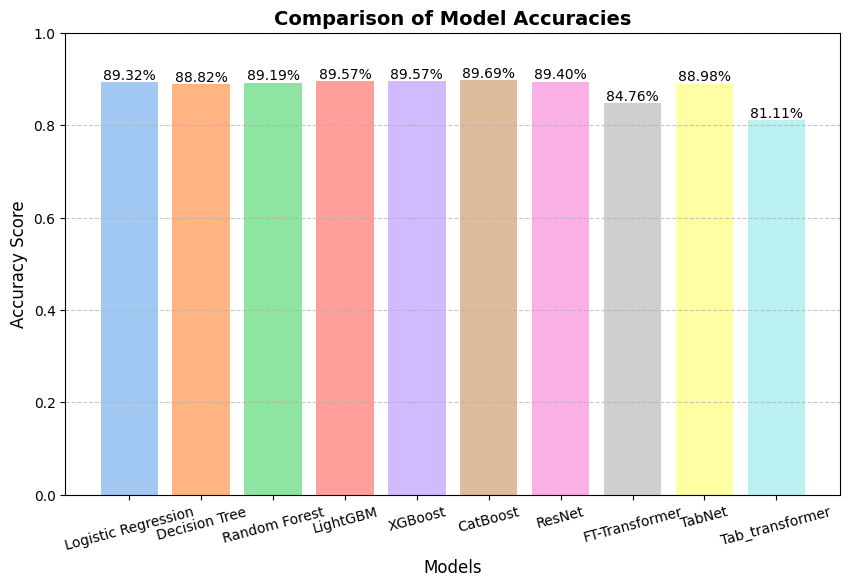

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'ResNet', 'FT-Transformer', 'TabNet', 'Tab_transformer']
accuracies = [log_acc, acc_dt, rf_acc, acc_lgb, acc_xgb, acc_cat, resnet_score, ftt_score, tabnet_score, tab_transformer_score]

colors = sns.color_palette("pastel", len(models))

plt.figure(figsize=(10, 6))

# 바 차트 그리기
bars = plt.bar(models, accuracies, color=colors,  linewidth=1.2)

plt.ylim(0, 1)

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{acc:.2%}",
             ha='center', va='bottom', fontsize=10)


plt.xlabel("Models", fontsize=12)
plt.ylabel("Accuracy Score", fontsize=12)
plt.title("Comparison of Model Accuracies", fontsize=14, fontweight='bold')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()